# Python: Estimation of Price Elasticities with Double/Debiased Machine Learning

![](figures/demand.png)

In this example, we will demonstrate the use of the [DoubleML](https://docs.doubleml.org/stable/index.html) package in a real-data industry example: Estimation of price elasticity of demand. This notebook is based on a [blogpost by Lars Roemheld (Roemheld, 2021)](https://towardsdatascience.com/causal-inference-example-elasticity-de4a3e2e621b) with code and preprocessed data being available from [GitHub](https://github.com/larsroemheld/causalinf_ex_elasticity). The original data file is made available as a public domain (CC0 1.0 Universal) data set and shared on [kaggle](https://www.kaggle.com/vijayuv/onlineretail). It contains data on sales from an online retailer in the period of December 2010 until December 2011.

The data preprocessing is performed in a [separate notebook that is available online](https://github.com/DoubleML/doubleml-docs/blob/master/doc/examples/py_elasticity_preprocessing.ipynb). To keep the computational effort at a moderate level, we will only use a subset of the data that is used in [Roemheld (2021)](https://towardsdatascience.com/causal-inference-example-elasticity-de4a3e2e621b). Our main goal is to illustrate the main steps of elasticity estimation with [DoubleML](https://docs.doubleml.org/stable/index.html).

The following case study is organized according to the steps of the [DoubleML workflow](https://docs.doubleml.org/stable/workflow/workflow.html).

## 0. Problem Formulation: Estimation of Price Elasticity of Demand

"Supply" and "demand" are probably the very first terms that economics and business students hear in their studies. In industry, the price elasticity of demand is a very important quantity: It indicates how much the demand for a product (= the quantity sold by the firm) changes due to a change in its price. As a retailer, this quantity is of great interest because it makes it possible to increase revenues, and eventually profits, by optimally adjusting prices according to elasticities.

The price elasticity of demand is formally defined as the relative change of the demanded quantity ($q$) of a product given a percent-change of the price ($p$)

$$\theta_0 = \frac{\partial q/q}{\partial p/p}.$$

In words, the parameter $\theta_0$ can be interpreted as follows: Provided the price for a product increases by $1\%$, the demanded quantity changes by $\theta_0\%$.

In general, it would be possible to estimate $\theta_0$ based on an experiment or A/B test. However, this is not possible in our case as the data set only contains information on actual purchases in the period of consideration.

The causal problem of price estimation based on an observational study is quite complex: It involves many (simultaneous) decisions made by the customers and the sellers. One approach for estimation of the causal parameter $\theta_0$ would be to account for confounding variables, that might have an effect to both the price and the quantity sold. The approach taken in  [Roemheld (2021)](https://towardsdatascience.com/causal-inference-example-elasticity-de4a3e2e621b) is to flexibly account for and construct confounding variables, for example including similarities in their product description or seasonal patterns, and thereby justifying identification of $\theta_0$.

We can use a [partially linear regression](https://docs.doubleml.org/stable/guide/models.html#partially-linear-regression-model-plr) (PLR) model for estimation of $\theta_0$

$$\log Q = \theta_0 \log P + g_0(X) + \zeta,$$

with $\mathbb{E}(\zeta|D,X)=0$. The confounders can enter the regression equation nonlinearily via the function $g_0(X)$. In order to equip $\theta_0$ (approximately) with the interpretation of a price elasticity, we applied the $\log()$ to both the demanded quantity ($Q$) and the prices ($P$), i.e., we set up a $\log$-$\log$-regression.

Before we proceed with the data analysis, it is important to mention a potential drawback to our analysis: The data only contains information on sales, not on stock days. Hence, based on this data set, it is not possible to assess what happened on days without sales (sales = 0). This drawback must be kept in mind when we draw causal conclusions from this analysis.

## 1. Data-Backend

To give an idea on the general setting we briefly load an exemplary data excerpt from the original data set. We can see that the data lists the transaction of a (online) retailer selling products like inflatable political globes or fancy pens.

In [1]:
# Load required modules
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.preprocessing
import pandas as pd, numpy as np
from datetime import datetime, date
from matplotlib import pyplot as plt
import seaborn as sns
import doubleml as dml
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [2]:
# Load example data set
url = 'https://raw.githubusercontent.com/DoubleML/doubleml-docs/master/doc/examples/data/orig_demand_data_example.csv'
data_example = pd.read_csv(url)
data_example

,Unnamed: 0,Date,StockCode,Country,Description,Quantity,revenue,UnitPrice
0,0,2010-12-01,10002,France,INFLATABLE POLITICAL GLOBE,48,40.80,0.850
1,1,2010-12-01,10002,United Kingdom,INFLATABLE POLITICAL GLOBE,12,10.20,0.850
2,2,2010-12-01,10125,United Kingdom,MINI FUNKY DESIGN TAPES,2,1.70,0.850
3,3,2010-12-01,10133,United Kingdom,COLOURING PENCILS BROWN TUBE,5,4.25,0.850
4,4,2010-12-01,10135,United Kingdom,COLOURING PENCILS BROWN TUBE,1,2.51,2.510
5,5,2010-12-01,11001,United Kingdom,ASSTD DESIGN RACING CAR PEN,3,10.08,3.360
6,6,2010-12-01,15044B,United Kingdom,BLUE PAPER PARASOL,1,2.95,2.950
7,7,2010-12-01,15056BL,United Kingdom,EDWARDIAN PARASOL BLACK,20,113.00,5.650
8,8,2010-12-01,15056N,United Kingdom,EDWARDIAN PARASOL NATURAL,50,236.30,4.726
9,9,2010-12-01,15056P,United Kingdom,EDWARDIAN PARASOL PINK,48,220.80,4.600


In our analysis, we will use a preprocessed data set. Each row corresponds to the sales of a product at a specific date $t$.

In the data we have, 

* `Quantity`: Quantity demanded
* `revenue`: Revenue
* `UnitPrice`: Price per unit
* `month`: Month
* `DoM`: Day of month
* `DoW`: Day of week
* `stock_age_days`: Number of days product has been sold / observed in the data
* `sku_avg_p`: Average (=median) price of the product
* `2010-12-01`, ...: Date dummies
* `Australia`, ...: Country dummies
* `1`, `2`, ... : Numerical variables constructed to capture similarities in product descriptions (n-grams)
* `dLnP`: Change in Price
* `dLnQ`: Change in Quantity

Note that we do not include product dummies as the price and quantity variables have been demeaned to account for product characteristics.

In [3]:
url2 = 'https://raw.githubusercontent.com/DoubleML/doubleml-docs/master/doc/examples/data/elasticity_subset.csv'
demand_data = pd.read_csv(url2)
print(demand_data.columns)

Index(['Unnamed: 0', 'Quantity', 'revenue', 'UnitPrice', 'month', 'DoM', 'DoW',
       'stock_age_days', 'sku_avg_p', '2010-12-01 00:00:00',
       ...
       '544', '545', '546', '547', '548', '549', '550', '551', 'dLnP', 'dLnQ'],
      dtype='object', length=906)


In [4]:
# Print dimensions of data set
print(demand_data.shape)

(10000, 906)


In [5]:
# Glimpse at first rows of data set
demand_data.head()

,Unnamed: 0,Quantity,revenue,UnitPrice,month,DoM,DoW,stock_age_days,sku_avg_p,2010-12-01 00:00:00,...,544,545,546,547,548,549,550,551,dLnP,dLnQ
0,189628,5,8.15,1.630000,9,6,1,278,0.85,0,...,0,0,0,0,0,0,0,0,0.408612,-1.013840
1,37914,19,41.93,2.206842,1,25,1,55,2.10,0,...,0,0,0,0,0,0,0,0,-0.048811,-0.306368
2,80103,24,20.40,0.850000,3,31,3,120,0.85,0,...,0,0,0,0,0,0,0,0,-0.127108,1.371479
3,75019,12,23.40,1.950000,3,24,3,113,2.08,0,...,0,0,0,0,0,0,0,0,-0.228256,-1.034483
4,99878,4,39.80,9.950000,5,5,3,155,9.95,0,...,0,0,0,0,0,0,0,0,-0.034922,-0.050881


To initiate the data backend, we create a new [DoubleMLData](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLData.html#doubleml.DoubleMLData) object. During instantiation, we assign the roles of the variables, i.e., `dLnQ` as the dependent var, `dLnP` as the treatment variable and the remaining variables as confounders.

In [6]:
feature_names = list(demand_data.columns[4:(demand_data.shape[1]-2),])

In [7]:
data_dml = dml.DoubleMLData(demand_data,
                            y_col = 'dLnQ',
                            d_cols = 'dLnP',
                            x_cols = feature_names)

In [8]:
print(data_dml)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: dLnQ
Treatment variable(s): ['dLnP']
Covariates: ['month', 'DoM', 'DoW', 'stock_age_days', 'sku_avg_p', '2010-12-01 00:00:00', '2010-12-02 00:00:00', '2010-12-03 00:00:00', '2010-12-05 00:00:00', '2010-12-06 00:00:00', '2010-12-07 00:00:00', '2010-12-08 00:00:00', '2010-12-09 00:00:00', '2010-12-10 00:00:00', '2010-12-12 00:00:00', '2010-12-13 00:00:00', '2010-12-14 00:00:00', '2010-12-15 00:00:00', '2010-12-16 00:00:00', '2010-12-17 00:00:00', '2010-12-19 00:00:00', '2010-12-20 00:00:00', '2010-12-21 00:00:00', '2010-12-22 00:00:00', '2010-12-23 00:00:00', '2011-01-04 00:00:00', '2011-01-05 00:00:00', '2011-01-06 00:00:00', '2011-01-07 00:00:00', '2011-01-09 00:00:00', '2011-01-10 00:00:00', '2011-01-11 00:00:00', '2011-01-12 00:00:00', '2011-01-13 00:00:00', '2011-01-14 00:00:00', '2011-01-16 00:00:00', '2011-01-17 00:00:00', '2011-01-18 00:00:00', '201

## 2. Causal Model 

We already stated that a partially linear regression model in a $\log$-$\log$-specification will allow us to interpret the regression coefficient $\theta_0$ as the price elasticity of demand. We restate the main regression as well as the auxiliary regression that is required for orthogonality


$$\begin{aligned}\log Q &= \theta_0 \log P + g_0(X) + \zeta,\\
\log P &= m_0(X) + V\end{aligned},$$

with $\mathbb{E}(\zeta|D,X)=0$ and $\mathbb{E}(V|X)=0$. As stated above, we hope to justify the assumption $\mathbb{E}(\zeta|D,X)=0$ by sufficiently accounting for the confounding variables $X$.


## 3. ML Methods

We start with the linear regression model as a benchmark lerner for learning nuisance parameters $g_0(X)$ and $m_0(X)$. We additionally set up two models based on a lasso learner as well as a random forest learner and compare our results.

In [9]:
ml_l_lin_reg = LinearRegression()
ml_m_lin_reg = LinearRegression()

In [10]:
Cs = 0.0001*np.logspace(0, 4, 10)
ml_l_lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=10000,
                                                     n_jobs = -1))
ml_m_lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=10000,
                                                     n_jobs = -1))

In [11]:
ml_l_forest = RandomForestRegressor(n_estimators=50,
                                    min_samples_leaf=3,
                                    n_jobs=-1, verbose=0)
ml_m_forest = RandomForestRegressor(n_estimators=50,
                                    min_samples_leaf=3,
                                    n_jobs=-1, verbose=0)

## 4. DML Specifications

For each learner configuration, we initialize a new [DoubleMLPLR](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLPLR.html) object. We stick to the default options, i.e., `dml_procedure = 'dml2'`, `score = "partialling out"`, n_folds = 5. 

In [12]:
np.random.seed(123)
dml_plr_lin_reg = dml.DoubleMLPLR(data_dml,
                                  ml_l = ml_l_lin_reg,
                                  ml_m = ml_m_lin_reg)

In [13]:
np.random.seed(123)
dml_plr_lasso = dml.DoubleMLPLR(data_dml,
                                ml_l = ml_l_lasso,
                                ml_m = ml_m_lasso)

In [14]:
np.random.seed(123)
dml_plr_forest = dml.DoubleMLPLR(data_dml,
                                 ml_l = ml_l_forest,
                                 ml_m = ml_m_forest)

## 5. Estimation 

To estimate our target parameter $\theta_0$, we call the `fit()` method. The results can be summarized by accessing the `summary` field.

In [15]:
dml_plr_lin_reg.fit(store_predictions = True)
summary_plr_lin_reg = dml_plr_lin_reg.summary
summary_plr_lin_reg

,coef,std err,t,P>|t|,2.5 %,97.5 %
dLnP,-0.725216,0.003777,-191.994849,0.0,-0.732619,-0.717813


In [16]:
dml_plr_lasso.fit(store_predictions = True)
summary_plr_lasso = dml_plr_lasso.summary
summary_plr_lasso

,coef,std err,t,P>|t|,2.5 %,97.5 %
dLnP,-1.81883,0.04411,-41.233963,0.0,-1.905284,-1.732376


In [17]:
dml_plr_forest.fit(store_predictions = True)
summary_plr_forest = dml_plr_forest.summary
summary_plr_forest

,coef,std err,t,P>|t|,2.5 %,97.5 %
dLnP,-1.800381,0.043246,-41.631025,0.0,-1.885142,-1.71562


Let us now compare how well the three models approximate the nuisance functions $g_0(X)$ and $m_0(X)$. We first define a helper function that calculates the RMSE for both.

In [18]:
from sklearn.metrics import mean_squared_error

def pred_acc_plr(DoubleML, nuis):
    """
    A function to calculate prediction accuracy values for every repetition
    of a Double Machine Learning model using PLR, DoubleMLPLR
    
    ...
    
    Parameters
    ----------
    DoubleML : doubleml.double_ml_plr.DoubleMLPLR
        The PLR Double Machine Learning model
    nuis : str
        Indicates nuisance component for evaluation of RMSE, either `'ml_l'` or `ml_m`.
    """
    
    # export data, fitted coefficient and predictions of the DoubleML model
    y = DoubleML._dml_data.y
    d = DoubleML._dml_data.d
    theta = DoubleML.coef
    ml_nuis = DoubleML.predictions.get(nuis)
    
    # dimensions of prediction array
    h = ml_nuis.shape[0]
    export_pred_array = np.zeros(h)      
    
    if nuis == 'ml_l':
        for j in range(h):
            export_pred_array[j] = theta*d[j] + ml_nuis[j]
    
    elif nuis == 'ml_m':
        for j in range(h):
            export_pred_array[j] = ml_nuis[j]

    rmse = mean_squared_error(y, export_pred_array, squared=False)
    
    return rmse

In [19]:
rmse_lin_reg_ml_l = pred_acc_plr(dml_plr_lin_reg, 'ml_l')
rmse_lin_reg_ml_m = pred_acc_plr(dml_plr_lin_reg, 'ml_m')

In [20]:
rmse_lasso_ml_l = pred_acc_plr(dml_plr_lasso, 'ml_l')
rmse_lasso_ml_m = pred_acc_plr(dml_plr_lasso, 'ml_m')

In [21]:
rmse_forest_ml_l = pred_acc_plr(dml_plr_forest, 'ml_l')
rmse_forest_ml_m = pred_acc_plr(dml_plr_forest, 'ml_m')

We visualize and compare the results in terms of the predictive performance.

In [22]:
plr_rmse_index = ['regression','lasso', 'forest']
plr_rmse = pd.DataFrame([[rmse_lin_reg_ml_l, rmse_lin_reg_ml_m],
                         [rmse_lasso_ml_l, rmse_lasso_ml_m],
                         [rmse_forest_ml_l, rmse_forest_ml_m]],
                        index=plr_rmse_index,
                        columns=['ml_l', 'ml_m'])
plr_rmse.round(3)

,ml_l,ml_m
regression,77729.446,107174.807
lasso,1.018,1.287
forest,1.019,1.292


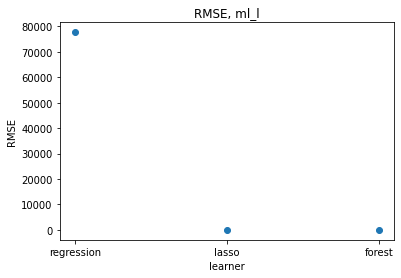

In [23]:
plt.scatter(x = plr_rmse_index, y= plr_rmse['ml_l'])
plt.title('RMSE, ml_l')
plt.xlabel('learner')
_ = plt.ylabel('RMSE')

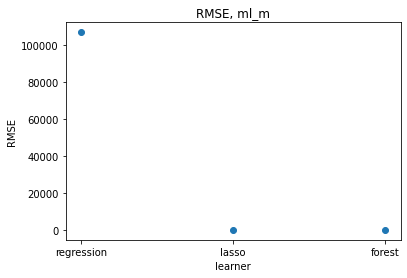

In [24]:
plt.scatter(x = plr_rmse_index, y= plr_rmse['ml_m'])
plt.title('RMSE, ml_m')
plt.xlabel('learner')
_ = plt.ylabel('RMSE')

## 7. Inference

We can visualize and summarize our findings so far. We can conclude that the price elasticity of demand, as indicated by the causal parameter $\theta_0$, is around $-1.8$. In all models, the coefficient is significantly different from zero.

In [25]:
plr_summary = pd.concat((summary_plr_lin_reg,
                         summary_plr_lasso,
                         summary_plr_forest))
plr_summary.index = ['linear regression', 'lasso', 'forest']
plr_summary[['coef', '2.5 %', '97.5 %']]

,coef,2.5 %,97.5 %
linear regression,-0.725216,-0.732619,-0.717813
lasso,-1.818830,-1.905284,-1.732376
forest,-1.800381,-1.885142,-1.715620


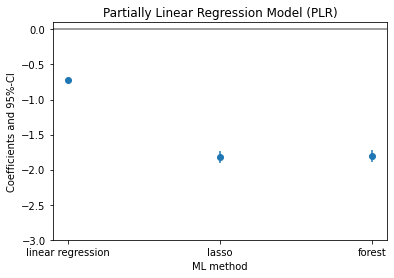

In [26]:
errors = np.full((2, plr_summary.shape[0]), np.nan)
errors[0, :] = plr_summary['coef'] - plr_summary['2.5 %']
errors[1, :] = plr_summary['97.5 %'] - plr_summary['coef']
plt.errorbar(plr_summary.index, plr_summary.coef, fmt='o', yerr=errors)
plt.axhline(y=0, color='gray')
plt.ylim([-3, 0.1])

plt.title('Partially Linear Regression Model (PLR)')
plt.xlabel('ML method')
_ =  plt.ylabel('Coefficients and 95%-CI')

______

**Acknowledgement**

We would like to thank [Lars Roemheld](https://www.larsroemheld.com/) for setting up the blog post on demand estimation using double machine learning as well as for sharing the code and preprocessed data set. We hope that with this notebook, we illustrate how to run such an analysis using [DoubleML](https://docs.doubleml.org/stable/index.html). Moreover, we would like to thank [Anzony Quispe](https://github.com/anzonyquispe) for excellent assistance in creating this notebook.
